In [ ]:
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
import tensorflow as tf
import torch
import torch.nn.functional as F
import os
import cv2
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv3D, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [4]:
MAIN_PATHS = ['../data/iaaa/iaaa_processed/T1/',
              '../data/iaaa/iaaa_processed/T2/',
              '../data/iaaa/iaaa_processed/FLAIR/']

In [5]:
def center_crop(image, target_height=224, target_width=224):

    original_height, original_width = image.shape[1], image.shape[2]

    offset_height = (original_height - target_height) // 2
    offset_width = (original_width - target_width) // 2
    
    cropped_image = image[:, 
                        offset_height:offset_height + target_height, 
                        offset_width:offset_width + target_width]

    return cropped_image


def enhance_contrast(image, alpha=1.0, beta=0.0):

    image = image.astype(np.float32)
    def enhance_contrast_for_image(image):

        channels = [image[i] for i in range(image.shape[-1])]
        enhanced_channels = [cv2.convertScaleAbs(c, alpha=alpha, beta=beta) for c in channels]
        contrast_enhanced_image = np.stack(enhanced_channels, axis=-1)
        
        return contrast_enhanced_image

    enhanced = np.array([enhance_contrast_for_image(img) for img in image])
    enhanced = enhanced.reshape(enhanced.shape[0], enhanced.shape[1], enhanced.shape[1])
    enhanced = np.array([cv2.transpose(s) for s in enhanced])
        
    return enhanced


def resize_tensor(tensor, target_size=(16, 64, 64)):
    target_depth, target_height, target_width = target_size
    
    resized_tensor = F.interpolate(tensor.unsqueeze(0), size=(target_height, target_width), mode='bilinear', align_corners=False).squeeze(0)
    
    current_depth = resized_tensor.size(0)
    if current_depth < target_depth:
        padding = (0, 0, 0, 0, 0, target_depth - current_depth)
        resized_tensor = F.pad(resized_tensor, padding, mode='constant', value=0)
    elif current_depth > target_depth:
        resized_tensor = resized_tensor[:target_depth, :, :]
    
    return resized_tensor

In [6]:
def dataset(main_paths): # returns images and labels lists.
  images = []
  labels = []
  for main_path in main_paths:
    for npz_file in os.listdir(main_path)[:]:
        if npz_file.endswith('.npz'):
            npz_file_path = os.path.join(main_path, npz_file)
            data = np.load(npz_file_path)
            image = data['x']
            image = image.astype(np.float32)
            image = center_crop(image)
            image = enhance_contrast(image)
            image = torch.tensor(image)
            image = resize_tensor(image)
            label = data['y']

            images.append(np.array(image))
            labels.append(label)

  return images, labels

In [7]:
images, labels = dataset(MAIN_PATHS)
X = np.array(images)
y = np.array(labels)
print(len(images))
print(len(labels))
print(X.shape)

3132
3132
(3132, 16, 64, 64)


#### Class Dist

(array([918., 126.]),
 array([0. , 0.5, 1. ]),
 <BarContainer object of 2 artists>)

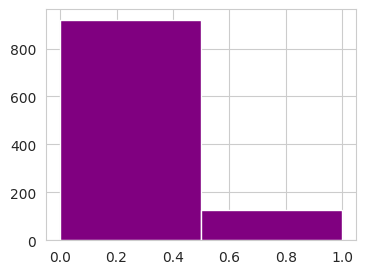

In [144]:
""" Class Dist For T1 """
plt.figure(figsize=(4,3))
plt.hist(labels, bins=2, color='purple')

(array([911., 133.]),
 array([0. , 0.5, 1. ]),
 <BarContainer object of 2 artists>)

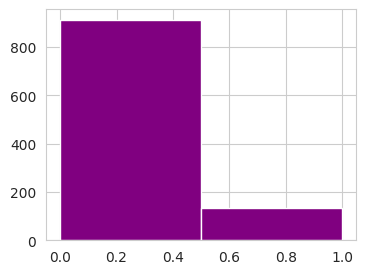

In [141]:
""" Class Dist For T2 """
plt.figure(figsize=(4,3))
plt.hist(labels, bins=2, color='purple')

(array([912., 132.]),
 array([0. , 0.5, 1. ]),
 <BarContainer object of 2 artists>)

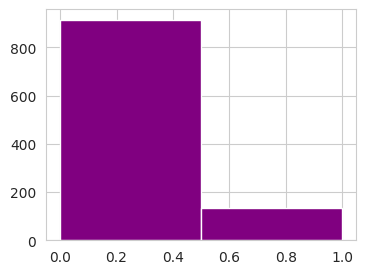

In [147]:
""" Class Dist For FLAIR """
plt.figure(figsize=(4,3))
plt.hist(labels, bins=2, color='purple')

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=25, shuffle=True)

(array([821., 119.]),
 array([0. , 0.5, 1. ]),
 <BarContainer object of 2 artists>)

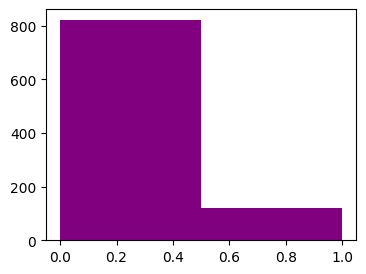

In [21]:
plt.figure(figsize=(4,3))
plt.hist(y_val, bins=2, color='purple')

#### Visualization

In [156]:
anormal_imgs = list()
for i, v in enumerate(labels):
    if v == 1:
        anormal_imgs.append(images[i])

len(anormal_imgs)
print('normal fraction:', 1 - (len(anormal_imgs)/len(images)))

normal fraction: 0.8751596424010217


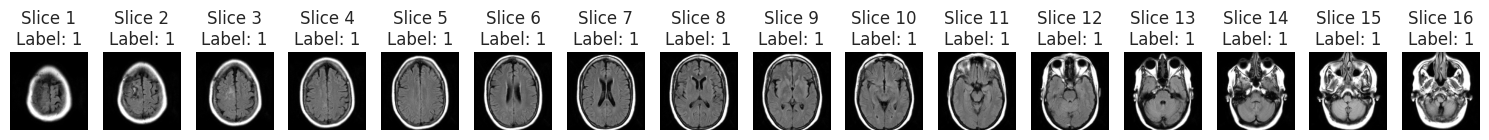

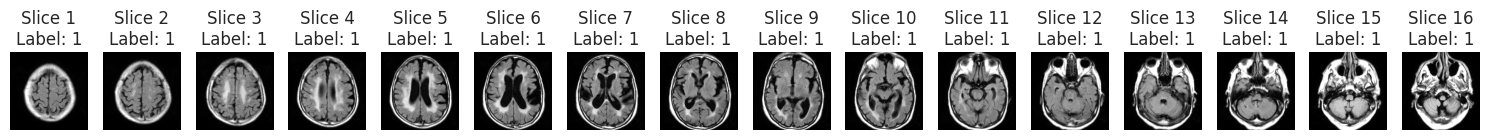

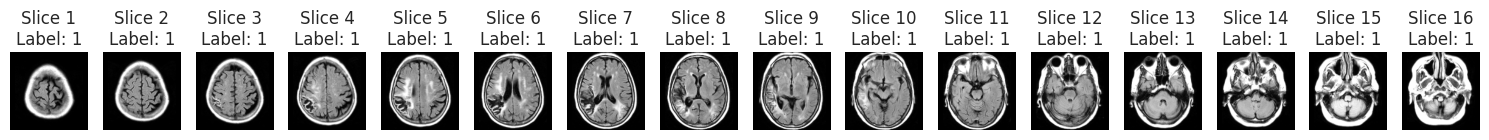

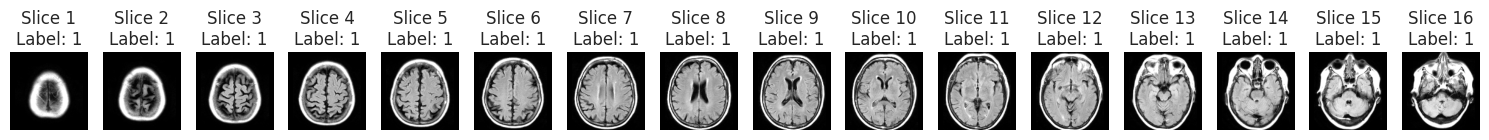

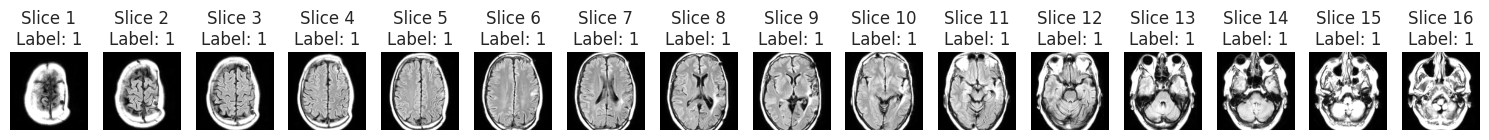

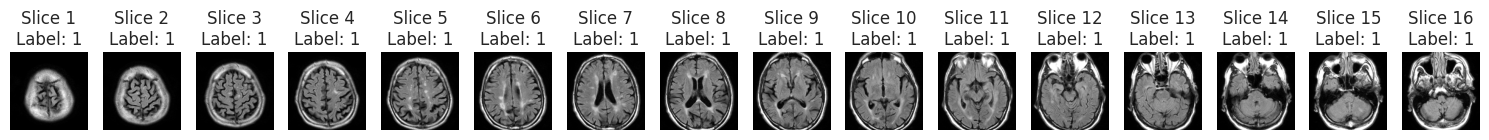

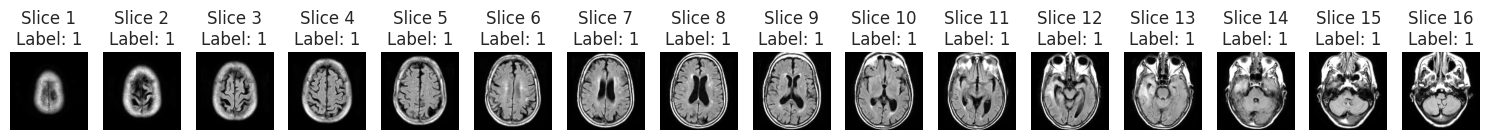

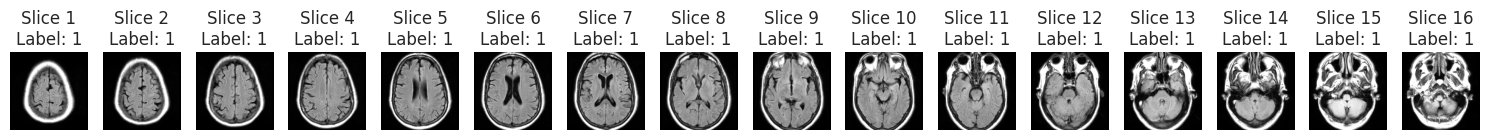

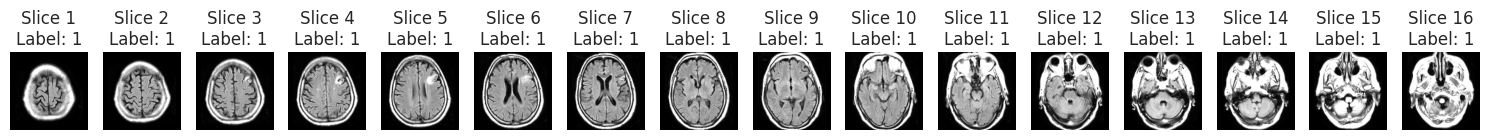

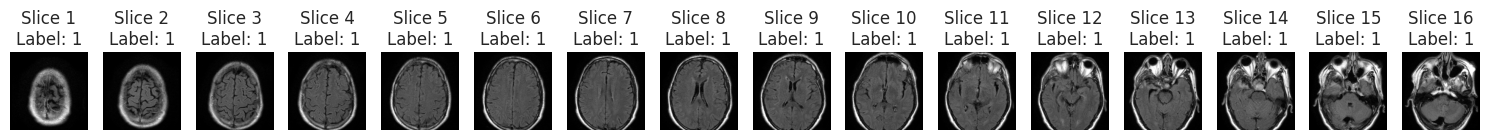

In [162]:
for anormal_img in anormal_imgs[350:360]:
    fig, axes = plt.subplots(nrows=1, ncols=len(anormal_img), figsize=(15, 5))

    for i, image in enumerate(anormal_img):
        if len(image) == 1:
            ax = axes
        else:
            ax = axes[i]

        ax.imshow(image, cmap='gray')
        ax.set_title(f'Slice {i+1}\nLabel: {1}')
        ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

## Model

In [ ]:
Lr = 0.001
bs = 20
epochs = 150

In [ ]:
tf.random.set_seed(100)
model = models.Sequential([
    Conv3D(32, (3, 3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(16, 64, 64, 1)),
    BatchNormalization(),
    Dropout(0.3),
    Conv3D(16, (3, 3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Conv3D(8, (3, 3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

Adam = keras.optimizers.Adam(learning_rate=Lr)
model.compile(optimizer=Adam, loss='binary_crossentropy', metrics=['accuracy', 'auc'])


In [6]:
def create_3d_cnn_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling3D((2, 2, 2), padding='same'))
    model.add(layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling3D((2, 2, 2), padding='same'))
    model.add(layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling3D((2, 2, 2), padding='same'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define input shape: (depth, height, width, channels)
input_shape = (16, 256, 256, 1)
model = create_3d_cnn_model(input_shape)
model.summary()

/home/mina/anaconda3/envs/mlenv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1723105282.106911   44082 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723105282.109644   44082 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723105282.109677   44082 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723105282.112780   44082 cu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 16, 256, 256,   │           896 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 8, 128, 128,    │             0 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 8, 128, 128,    │        55,360 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 4, 64, 64, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 4, 64, 64, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 2, 32, 32, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    16,777,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,054,913 (65.06 MB)

 Trainable params: 17,054,913 (65.06 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
history = model.fit(X_train, y_train, epochs=10, batch_size=8, validation_data=(X_val, y_val))

Epoch 1/10


I0000 00:00:1723105315.645937   44447 service.cc:146] XLA service 0x7fb7fc004650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723105315.645980   44447 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-08-08 11:51:55.663486: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-08 11:51:58.099541: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902
2024-08-08 11:52:00.226289: W external/local_xla/xla/stream_executor/gpu/redzone_allocator_kernel_cuda.cc:136] NOT_FOUND: Couldn't find a suitable version of ptxas. The following locations were considered: ./cuda_sdk_lib/bin/ptxas, /home/mina/anaconda3/envs/mlenv/bin/ptxas, /home/mina/.vscode-server/bin/b1c0a14de1414fcdaa400695b4db1c0799bc3124/bin/remote-cli/ptxas, /home/mina/.local/b

NotFoundError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/home/mina/anaconda3/envs/mlenv/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/home/mina/anaconda3/envs/mlenv/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/mina/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/mina/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1053, in launch_instance

  File "/home/mina/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 737, in start

  File "/home/mina/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/mina/anaconda3/envs/mlenv/lib/python3.10/asyncio/base_events.py", line 595, in run_forever

  File "/home/mina/anaconda3/envs/mlenv/lib/python3.10/asyncio/base_events.py", line 1881, in _run_once

  File "/home/mina/anaconda3/envs/mlenv/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/mina/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 524, in dispatch_queue

  File "/home/mina/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in process_one

  File "/home/mina/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 418, in dispatch_shell

  File "/home/mina/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 758, in execute_request

  File "/home/mina/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 426, in do_execute

  File "/home/mina/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/mina/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3046, in run_cell

  File "/home/mina/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3101, in _run_cell

  File "/home/mina/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/mina/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3306, in run_cell_async

  File "/home/mina/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3488, in run_ast_nodes

  File "/home/mina/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3548, in run_code

  File "/tmp/ipykernel_44082/3100217567.py", line 2, in <module>

  File "/home/mina/anaconda3/envs/mlenv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/mina/anaconda3/envs/mlenv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit

  File "/home/mina/anaconda3/envs/mlenv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

Couldn't find a suitable version of ptxas. The following locations were considered: ./cuda_sdk_lib/bin/ptxas, /home/mina/anaconda3/envs/mlenv/bin/ptxas, /home/mina/.vscode-server/bin/b1c0a14de1414fcdaa400695b4db1c0799bc3124/bin/remote-cli/ptxas, /home/mina/.local/bin/ptxas, /home/mina/anaconda3/envs/mlenv/bin/ptxas, /home/mina/anaconda3/condabin/ptxas, /usr/local/sbin/ptxas, /usr/local/bin/ptxas, /usr/sbin/ptxas, /usr/bin/ptxas, /sbin/ptxas, /bin/ptxas, /usr/games/ptxas, /usr/local/games/ptxas, /usr/lib/wsl/lib/ptxas, /mnt/c/Windows/system32/ptxas, /mnt/c/Windows/ptxas, /mnt/c/Windows/System32/Wbem/ptxas, /mnt/c/Windows/System32/WindowsPowerShell/v1.0/ptxas, /mnt/c/Windows/System32/OpenSSH/ptxas, /mnt/c/Program Files (x86)/NVIDIA Corporation/PhysX/Common/ptxas, /mnt/c/Program Files/Microsoft SQL Server/150/Tools/Binn/ptxas, /mnt/c/Program Files/Microsoft SQL Server/Client SDK/ODBC/170/Tools/Binn/ptxas, /mnt/c/Program Files/dotnet/ptxas, /mnt/c/Program Files (x86)/Windows Kits/10/Windows Performance Toolkit/ptxas, /mnt/c/Program Files/PostgreSQL/16/bin/ptxas, /mnt/c/Program Files/PuTTY/ptxas, /mnt/c/Program Files/Cloudflare/Cloudflare WARP/ptxas, /mnt/c/Users/mina/anaconda3/ptxas, /mnt/c/Users/mina/anaconda3/Library/mingw-w64/bin/ptxas, /mnt/c/Users/mina/anaconda3/Library/usr/bin/ptxas, /mnt/c/Users/mina/anaconda3/Library/bin/ptxas, /mnt/c/Users/mina/anaconda3/Scripts/ptxas, /mnt/c/Users/mina/AppData/Local/Microsoft/WindowsApps/ptxas, /mnt/c/Users/mina/.dotnet/tools/ptxas, /mnt/c/Users/mina/AppData/Local/Programs/Microsoft VS Code/bin/ptxas, /mnt/c/Program Files/PostgreSQL/16/bin/ptxas, /snap/bin/ptxas, /usr/local/cuda-12.3/bin/ptxas, /usr/local/cuda/bin/ptxas, /home/mina/anaconda3/envs/mlenv/lib/python3.10/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc/bin/ptxas, /home/mina/anaconda3/envs/mlenv/lib/python3.10/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc/bin/ptxas
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_iterator_1994]